### Imports

In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from curved_edges import curved_edges
import random
import math

### Data Structure

In [2]:
with open("data.json", 'r') as f:
    data = json.load(f)

for k in data:
    for key in data[k]:
        print(key)
    break
    
artists = set()
for k in data:
    for a in data[k]["artists"]:
        artists.add(a)

processed_tracks
venue
tracks
duplicate
artists
date
tracklist
categories


### Artist Sanitization
Location data leaks through as a parenthetical. A good example is Carl Cox. The goal here is to make a rectangular dataset that will look like:

```
mix_artist | mix_date | track_artist | track_name | mix_style 
...          ...        ...            ...          ...
```

Sanitization of track artists isn't as necessary because location data didn't leak through. Mix style is included in the full json file

In [3]:
for a in artists:
    if "carl cox" in a.lower() and a != "Carl Cox":
        print(a)

Carl Cox (Street Parade
Carl Cox (Space)
Carl Cox (South Africa)
Carl Cox (Space Terrace)
Carl Cox in Mexico City


This is a list of every artist name that may have a problem with it

In [4]:
def has_problem(s):
    bad_str = ["(", " b2b ", " in "]
    if any(b in s for b in bad_str): return True
    else: return False
    
for a in artists:
    if has_problem(a): print(a)

Frankie Knuckles (XOYO)
Danny Tenaglia (Heavens 4th Birthday Party)
Heidi b2b Miss Kittin
Carl Cox (Street Parade
VA (Sunderland)
Pete Tong b2b Eats Everything
Melé b2b Themba
Josh Wink (WMC)
Paul Oakenfold (Rojam
Sasha b2b Pete Tong
Judge Jules (3 Years Sundissential
Booka Shade (Live PA)
Danny Rampling (Christmas Special)
Pete Tong (KU)
Steve Lawler b2b Nic Fanciulli b2b Eli & Fur
John Digweed (Homelands)
Joy Orbison b2b Ben UFO
Timo Maas (Boom
Caribou (Essential Mix Of The Year)
Carl Cox (Space)
Paul van Dyk (Casino)
Chris Liebing b2b Charlotte de Witte
Âme b2b Dixon
Paul Woolford b2b James Zabiela
Carl Cox (South Africa)
Air (Part 2)
Air (Part 1)
The Chemical Brothers (Live PA)
Pete Tong (8 Years Club Class)
Carl Cox (Space Terrace)
VA (Ibiza Repeats)
Chemical Brothers (Live PA)
Ricky Morrison & Fram Silodi (M & S)
Paul Oakenfold (The Goa Mix)
Judge Jules (Ibiza Special)
Rudimental (Glastonbury Archive)
Carl Cox in Mexico City
Patrick Topping b2b Richy Ahmed
Sasha (Que Club)
Harri 

Steps to sanitize:
 - Call .strip()
 - Force lowercase
 - Remove all apostrophes
 - Remove all text after a right parentheses
 - Remove all text after the word " in "

b2b artists won't be sanitized. Instead, each track in that set will count as one play for both artists.

In [6]:
def sanitize_artist(s):
    s = s.replace("'", "") # Remove apostrophes
    
    #  Remove location data
    bad_chars = ["(", " in ", "[", "@"]
    for bad in bad_chars:
        if bad in  s:
            paren_ind = s.find(bad)
            if s[paren_ind-1] == " ": paren_ind -= 1
            s = s[:paren_ind]
    
    s = s.strip().lower()
    # Return multiple artists if this is a b2b set
    if " b2b " in s:
        ret = s.split(" b2b ")
    else:
        ret = [s]
    
    return ret

for a in random.sample(artists, len(artists) // 100):
    new_a = sanitize_artist(a)
    print("{} ==> {}".format(a, new_a))

Adam Sheridan ==> ['adam sheridan']
Butch ==> ['butch']
Tim Green ==> ['tim green']
Rhythm Masters ==> ['rhythm masters']
DJ Pierre ==> ['dj pierre']
Judge Jules (3 Years Sundissential ==> ['judge jules']
Pete Tong ==> ['pete tong']
Sean Tyas ==> ['sean tyas']
The Gaslamp Killer ==> ['the gaslamp killer']


Multiple artists present a challenge. The partially-processed track data array includes a note on when artists took over for different sections of a mix (denoted by a semicolon). We can use this to attribute plays correctly.

In [7]:
# Load in categories
with open("categories.json", 'r') as f:
    cat_dict = json.load(f)
    
def sanitize_output(s):
    s = s.lower().strip()
    s = s.replace(",", ".")
    return s

with open("data_rectangular.csv", 'w', encoding="utf-8") as out:
    out.write("mix_artist,mix_date,mix_style,track_artist,track_name\n")
    
    for mix in data:
        if data[mix]["duplicate"]: continue # Ignore duplicates in the data
        
        artists_processed  = []
        for partial in list(map(sanitize_artist, data[mix]["artists"])):
            artists_processed += partial
        
        # Special case: VA gets read as one artist even though there are multiple artists in the set
        if data[mix]["artists"][0] == "VA" and len(data[mix]["artists"]) == 1:
            # Need to parse artists from unprocessed tracks manually
            artists_processed = []
            for t in data[mix]["tracks"]:
                if t[0] == ';': # This line has artist information
                    artists_processed += sanitize_artist(t[1:])
        
        # Determine mix category
        if data[mix]["categories"]:
            for c in data[mix]["categories"]:
                if c in cat_dict:
                    mix_cat = cat_dict[c]
        else:
            mix_cat = "unknown"
        
        # Assign date
        date = data[mix]["date"]
        
        multiple_artists = len(data[mix]["artists"]) > 1
        if multiple_artists:
            # Iterate over part-processed tracks in tandem
            a_ind = -1
            t_ind = 0
            for track in data[mix]["processed_tracks"]:
                if data[mix]["tracks"][t_ind][0] == ";" and a_ind != len(artists_processed) - 1: a_ind += 1
                #print(",".join([artists_processed[a_ind], date, track[0], track[1]]))
                if any(t == "?" or t.lower() == "unknown" for t in track[:2]): continue
                out.write(",".join(map(sanitize_output, [artists_processed[a_ind], date, mix_cat, track[0], track[1]])) + "\n")
                t_ind += 1
            
        else:
            # Attribute each track to each artist
            for artist in artists_processed:
                for track in data[mix]["processed_tracks"]:
                    #print(",".join([artist, date, track[0], track[1]]))
                    if any(t == "?" or t.lower() == "unknown" for t in track[:2]): continue
                    out.write(",".join(map(sanitize_output, [artist, date, mix_cat, track[0], track[1]])) + "\n")

There's a few manual corrections for egregious errors. Reloading the file so those carry over.

In [8]:
rect = pd.read_csv("data_rectangular.csv")
rect.head()

,mix_artist,mix_date,mix_style,track_artist,track_name
0,paul woolford,2010-09-25,house,shed,stp2
1,paul woolford,2010-09-25,house,conforce,shade
2,paul woolford,2010-09-25,house,pherox,road days
3,paul woolford,2010-09-25,house,pherox,rude vox
4,paul woolford,2010-09-25,house,geggenheimer,earth version 2


Now the goal is to construct a graph where nodes are individual artists and edges are a case when one artist played another's track in their essential mix. We will call each of these events a "crossplay". Each of the edges will additionally be colored by the style of mix where the crossplay occurred.

In [9]:
all_artists = set(rect["mix_artist"])
print(len(all_artists))

919


In [10]:
# Key: mix artist
# Value: set of track artists
cross_dict = {}
# Key : mix artist
# Value: dict of {style : count}
style_dict = {}
def check_crossplay(mix_artist, track_artist, style):
    if track_artist in all_artists and track_artist != mix_artist:
        # Found a crossplay.
        key1 = mix_artist
        key2 = track_artist
        
        if key1 not in cross_dict: cross_dict[key1] = style, set()
        if key2 not in cross_dict[key1]: cross_dict[key1][1].add(key2)      

for ind in rect.index:
    m_artist = rect["mix_artist"][ind]
    t_artist = rect["track_artist"][ind]
    style = rect["mix_style"][ind]
    
    check_crossplay(m_artist, t_artist, style)
    
    if m_artist not in style_dict: style_dict[m_artist] = dict()
    
    if style not in style_dict[m_artist]: style_dict[m_artist][style] = 1
    else: style_dict[m_artist][style] += 1

print(style_dict["carl cox"])        

# Collapse style_dict into key/value pairs of an artists most-played genre
for artist, counts in style_dict.items():
    style_dict[artist] = max(counts.keys(), key=lambda x: counts[x])

{'techno': 903, 'house': 426, 'trance': 11}


In [11]:
print(set(style_dict.values()))

{'house', 'breaks', 'rhythm', 'bass', 'techno', 'pop', 'trance'}


Artists generally have multiple styles in their discography, so we count up each type and take the most common one.

### Visualization with NetworkX

In [12]:
# Write edge data to a file
with open("edges.txt", 'w', encoding="utf-8") as f:
    for key, val in cross_dict.items():
        style = val[0]
        for a in val[1]:
            f.write('{0},{1}'.format(key, a) + "\n")

In [13]:
# Map styles to colors
colormap = {"house" : "orange",
            "breaks" : "red",
            "pop" : "fuchsia",
            "trance" : "aqua",
            "bass" : "blue",
            "techno" : "lime",
            "rhythm" : "yellow"}

# Count up occurrences of each genre
genre_counts = {g:list(style_dict.values()).count(g) for g in set(style_dict.values())}

In [15]:
# see https://stackoverflow.com/questions/52588453/creating-curved-edges-with-networkx-in-python3
plt.style.use("dark_background")
FIG_SIZE = 15

# Generate nodes and create Graph
nodes = list(style_dict.keys())
nodes.sort(key=lambda x: colormap[style_dict[x]])
G = nx.Graph()
G.add_nodes_from(nodes)

# Read in edges from file and add
for line in open("edges.txt"):
    u, v = tuple(line.strip().split(","))
    if u not in G.nodes() or v not in G.nodes(): continue
    G.add_edge(u, v)

# Style information
nodecolor = [colormap[style_dict[a]] for a in nodes]
edgecolor = [colormap[style_dict[e[0]]] for e in G.edges()]

# Compute node positions
positions = nx.circular_layout(G, scale=FIG_SIZE)

# Produce the curves
curves = curved_edges(G, positions)
lc = LineCollection(curves, color=edgecolor, alpha=0.03)

C:\Users\ganzk\Desktop\tracklists\curved_edges.py:39: RuntimeWarning: divide by zero encountered in true_divide
  m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])
C:\Users\ganzk\Desktop\tracklists\curved_edges.py:46: RuntimeWarning: invalid value encountered in multiply
  coords_node1_displace = coords_node1 + (v1*t1).T
C:\Users\ganzk\Desktop\tracklists\curved_edges.py:47: RuntimeWarning: invalid value encountered in multiply
  coords_node2_displace = coords_node2 - (v1*t1).T


In [16]:
# Plot
def plot_graph():
    # Create figure and get axes
    fig = plt.figure(figsize=(FIG_SIZE,FIG_SIZE))
    ax = plt.gca()
    ax.set_facecolor("black")
    ax.add_collection(lc)
    legend_elements = [Line2D([0], [0], color=c, lw=4, label=g.title()) for g,c in colormap.items()]
    ax.legend(handles=legend_elements, loc="lower right", fontsize=12)
    nx.draw_networkx_nodes(G, positions, node_size=5, node_color=nodecolor, alpha=1)
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
    plt.title("Essential Mix Crosstalk", loc="left", fontsize=18)
    plt.text(0.005, 0.99, "Lines represent one artist playing the other's track in their set, colored by genre", 
             fontsize=12, color="grey", ha="left", va="center", transform=ax.transAxes)
    plt.text(0.005, 0.01, "Data source: mixesdb.com", 
             fontsize=12, color="grey", ha="left", va="center", transform=ax.transAxes)
    plt.savefig("crosstalk.png", dpi=200)
    plt.show()
    

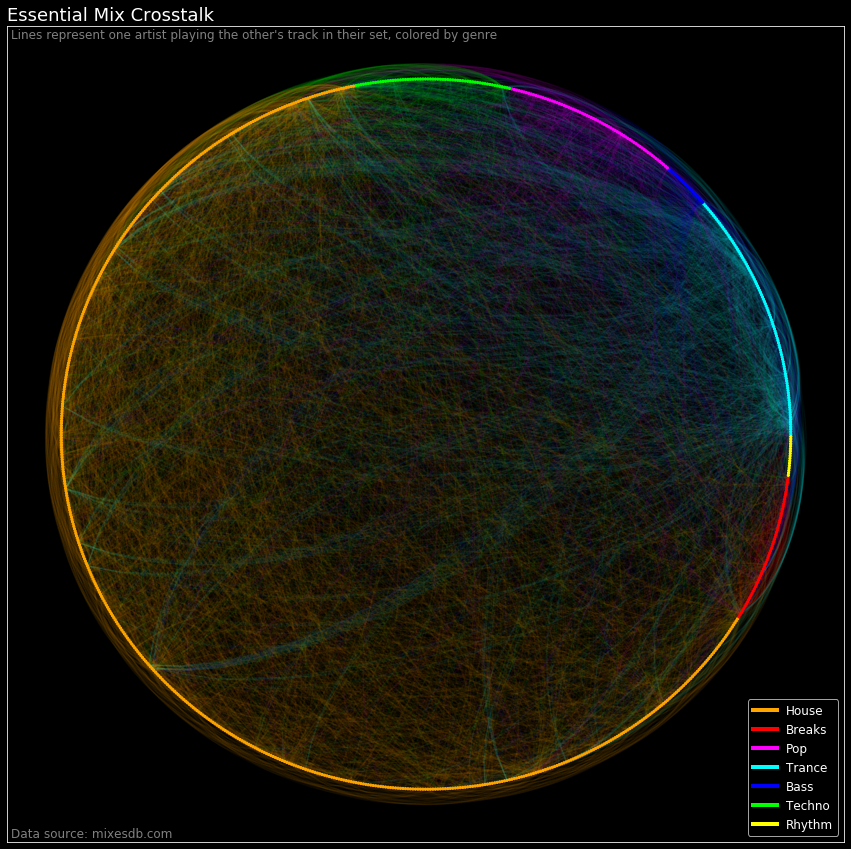

In [17]:
plot_graph()

That's a good start, but arranging each artist in a circle could be improved upon. To see the relationships between genres, we can place each color at a point and place individual artists around that anchor (like `geom_jitter` in R's tidyverse).

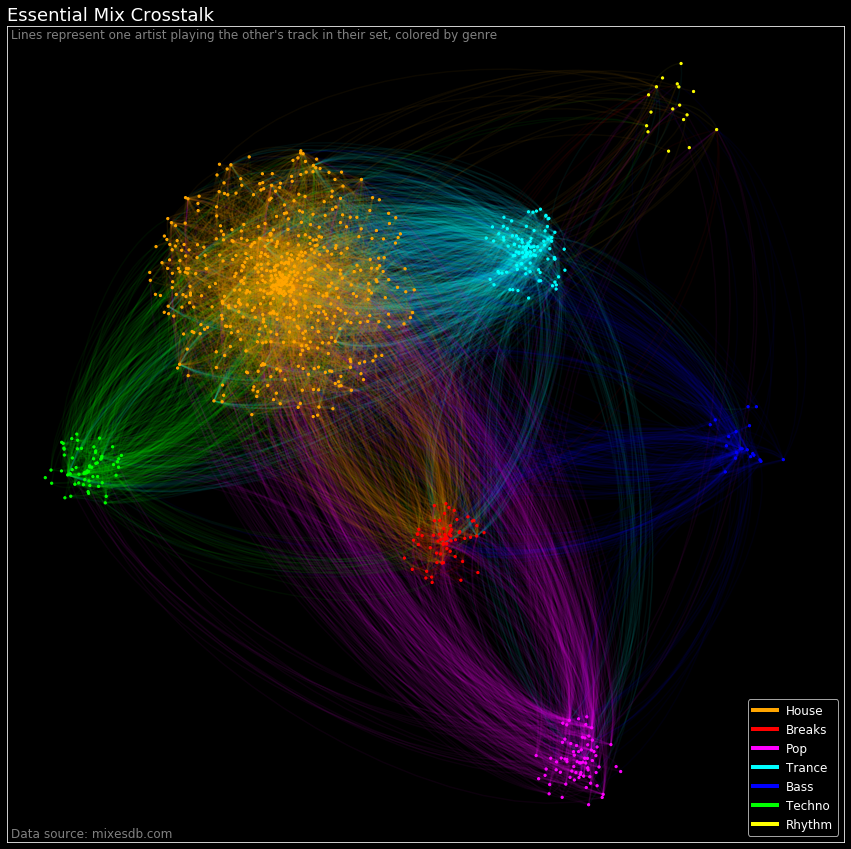

In [18]:
import numpy as np

genres = list(colormap.keys())
anchor_points = dict()
positions = dict()
buffer_radius = 7

def rand_coord():
    return random.uniform(-FIG_SIZE, FIG_SIZE)

def dist(x1, y1, x2, y2):
    return np.sqrt((x1-x2) ** 2 + (y1-y2) ** 2)

for genre in genres:
    x, y = rand_coord(), rand_coord()
    while any(dist(x, y, v[0], v[1]) < buffer_radius for v in anchor_points.values()):
        x, y = rand_coord(), rand_coord()
    
    anchor_points[genre] = (x, y)

for a in G.nodes():
    # Determine which genre this node belongs to, set size multiplier
    g = style_dict[a]
    # Compute x and y by placing in a circle with radius dependent on the number of artists
    # in that genre
    theta = random.uniform(0, 2 * math.pi)
    r = random.uniform(0, max(2, genre_counts[g] / 100))
    ax = anchor_points[g][0] + math.cos(theta) * r
    ay = anchor_points[g][1] + math.sin(theta) * r
    positions[a] = [ax, ay]

# Produce the curves
curves = curved_edges(G, positions)
lc = LineCollection(curves, color=edgecolor, alpha=0.05)
plot_graph()

## Which genres sample the most from other genres?

In [ ]:
xplay_counts = {s:{"in": 0, "out": 0} for s in style_dict.values()}

for ind in rect.index:
    m_artist = rect["mix_artist"][ind]
    t_artist = rect["track_artist"][ind]
    style = rect["mix_style"][ind]
    
    if t_artist in style_dict:
        in_or_out = "in" if style_dict[t_artist] == style else "out"
        xplay_counts[style][in_or_out] += 1

In [ ]:
xplay_counts

In [ ]:
from math import log2
plt.style.use("ggplot")

styles = list(xplay_counts.keys())
ratios = [log2(xplay_counts[s]["in"] / xplay_counts[s]["out"]) for s in styles]
x_pos = [idx for idx, _ in enumerate(styles)]
barcolor = [colormap[s] for s in styles]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x_pos, ratios)
plt.xticks(x_pos, styles)
minx, maxx = plt.xlim()
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Log2 (inside-genre plays / outside-genre plays)", fontsize=15)
plt.title("DJs Generally Play Tracks From Their Own Genre")
plt.savefig("bars.png", dpi=200)

## How Many Tracks in a Set?

In [ ]:
# Highest 